In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

# Training and evaluating quantum kernels


Kernel methods are one of the cornerstones of classical machine learning. Here we are concerned with kernels that can be evaluated on quantum computers, *quantum kernels* for short. In this tutorial you will learn how to evaluate kernels, use them for classification and train them with gradient-based optimization, and all that using the functionality of PennyLane\'s [kernels module](https://pennylane.readthedocs.io/en/latest/code/qml_kernels.html).

## What are kernel methods?


To understand what a kernel method does, let\'s first revisit one of the simplest methods to assign binary labels to datapoints: linear classification.

Imagine we want to discern two different classes of points that lie in different corners of the plane. A linear classifier corresponds to drawing a line and assigning different labels to the regions on opposing
sides of the line:

![](images/linear_classification.png)

We can mathematically formalize this by assigning the label $y$ via

$$y(\boldsymbol{x}) = \operatorname{sgn}(\langle \boldsymbol{w}, \boldsymbol{x}\rangle + b).$$

The vector $\boldsymbol{w}$ points perpendicular to the line and thus determine its slope. The independent term $b$ specifies the position on the plane. In this form, linear classification can also be extended to higher dimensional vectors $\boldsymbol{x}$, where a line does not divide the entire space into two regions anymore. Instead one needs a *hyperplane*. It is immediately clear that this method is not very powerful, as datasets that are not separable by a hyperplane can\'t be classified without error.

We can actually sneak around this limitation by performing a neat trick: if we define some map $\phi(\boldsymbol{x})$ that *embeds* our datapoints into a larger *feature space* and then perform linear
classification there, we could actually realise non-linear classification in our original space!

![](images/embedding_nonlinear_classification.png)

If we go back to the expression for our prediction and include the embedding, we get

$$y(\boldsymbol{x}) = \operatorname{sgn}(\langle \boldsymbol{w}, \phi(\boldsymbol{x})\rangle + b).$$

We will forgo one tiny step, but it can be shown that for the purpose of optimal classification, we can choose the vector defining the decision boundary as a linear combination of the embedded datapoints
$\boldsymbol{w} = \sum_i \alpha_i \phi(\boldsymbol{x}_i)$. Putting this into the formula yields

$$y(\boldsymbol{x}) = \operatorname{sgn}\left(\sum_i \alpha_i \langle \phi(\boldsymbol{x}_i), \phi(\boldsymbol{x})\rangle + b\right).$$

This rewriting might not seem useful at first, but notice the above formula only contains inner products between vectors in the embedding space:

$$k(\boldsymbol{x}_i, \boldsymbol{x}_j) = \langle \phi(\boldsymbol{x}_i), \phi(\boldsymbol{x}_j)\rangle.$$

We call this function the *kernel*. It provides the advantage that we can often find an explicit formula for the kernel $k$ that makes it superfluous to actually perform the (potentially expensive) embedding $\phi$. Consider for example the following embedding and the associated kernel:

$$\begin{aligned}
\phi((x_1, x_2)) &= (x_1^2, \sqrt{2} x_1 x_2, x_2^2) \\
k(\boldsymbol{x}, \boldsymbol{y}) &= x_1^2 y_1^2 + 2 x_1 x_2 y_1 y_2 + x_2^2 y_2^2 = \langle \boldsymbol{x}, \boldsymbol{y} \rangle^2.
\end{aligned}$$

This means by just replacing the regular scalar product in our linear classification with the map $k$, we can actually express much more intricate decision boundaries!

This is very important, because in many interesting cases the embedding $\phi$ will be much costlier to compute than the kernel $k$.

In this demo, we will explore one particular kind of kernel that can be realized on near-term quantum computers, namely *Quantum Embedding Kernels (QEKs)*. These are kernels that arise from embedding data into
the space of quantum states. We formalize this by considering a parameterised quantum circuit $U(\boldsymbol{x})$ that maps a datapoint $\boldsymbol{x}$ to the state

$$|\psi(\boldsymbol{x})\rangle = U(\boldsymbol{x}) |0 \rangle.$$

The kernel value is then given by the *overlap* of the associated embedded quantum states

$$k(\boldsymbol{x}_i, \boldsymbol{x}_j) = | \langle\psi(\boldsymbol{x}_i)|\psi(\boldsymbol{x}_j)\rangle|^2.$$


## A toy problem


In this demo, we will treat a toy problem that showcases the inner workings of classification with quantum embedding kernels, training variational embedding kernels and the available functionalities to do both in PennyLane. We of course need to start with some imports:


In [2]:
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)

And we proceed right away to create a dataset to work with, the `DoubleCake` dataset. Firstly, we define two functions to enable us to generate the data. The details of these functions are not essential for understanding the demo, so don\'t mind them if they are confusing.


In [3]:
def _make_circular_data(num_sectors):
    """Generate datapoints arranged in an even circle."""
    center_indices = np.array(range(0, num_sectors))
    sector_angle = 2 * np.pi / num_sectors
    angles = (center_indices + 0.5) * sector_angle
    x = 0.7 * np.cos(angles)
    y = 0.7 * np.sin(angles)
    labels = 2 * np.remainder(np.floor_divide(angles, sector_angle), 2) - 1

    return x, y, labels


def make_double_cake_data(num_sectors):
    x1, y1, labels1 = _make_circular_data(num_sectors)
    x2, y2, labels2 = _make_circular_data(num_sectors)

    # x and y coordinates of the datapoints
    x = np.hstack([x1, 0.5 * x2])
    y = np.hstack([y1, 0.5 * y2])

    # Canonical form of dataset
    X = np.vstack([x, y]).T

    labels = np.hstack([labels1, -1 * labels2])

    # Canonical form of labels
    Y = labels.astype(int)

    return X, Y

Next, we define a function to help plot the `DoubleCake` data:


In [4]:
def plot_double_cake_data(X, Y, ax, num_sectors=None):
    """Plot double cake data and corresponding sectors."""
    x, y = X.T
    cmap = mpl.colors.ListedColormap(["#FF0000", "#0000FF"])
    ax.scatter(x, y, c=Y, cmap=cmap, s=25, marker="s")

    if num_sectors is not None:
        sector_angle = 360 / num_sectors
        for i in range(num_sectors):
            color = ["#FF0000", "#0000FF"][(i % 2)]
            other_color = ["#FF0000", "#0000FF"][((i + 1) % 2)]
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    1,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=color,
                    alpha=0.1,
                    width=0.5,
                )
            )
            ax.add_artist(
                mpl.patches.Wedge(
                    (0, 0),
                    0.5,
                    i * sector_angle,
                    (i + 1) * sector_angle,
                    lw=0,
                    color=other_color,
                    alpha=0.1,
                )
            )
            ax.set_xlim(-1, 1)

    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.axis("off")

    return ax

Let\'s now have a look at our dataset. In our example, we will work with
3 sectors:


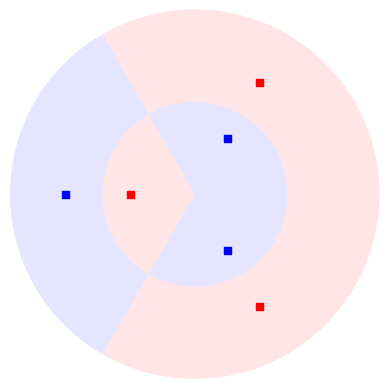

In [5]:
import matplotlib.pyplot as plt

num_sectors = 3
X, Y = make_double_cake_data(num_sectors)

ax = plot_double_cake_data(X, Y, plt.gca(), num_sectors=num_sectors)

## Defining a Quantum Embedding Kernel


PennyLane\'s [kernels module](https://pennylane.readthedocs.io/en/latest/code/qml_kernels.html) allows for a particularly simple implementation of Quantum Embedding Kernels. The first ingredient we need for this is an *ansatz*, which we will construct by repeating a layer as building block. Let\'s start by defining this layer:


In [6]:
import pennylane as qml


def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

To construct the ansatz, this layer is repeated multiple times, reusing the datapoint `x` but feeding different variational parameters `params` into each of them. Together, the datapoint and the variational
parameters fully determine the embedding ansatz $U(\boldsymbol{x})$. In order to construct the full kernel circuit, we also require its adjoint $U(\boldsymbol{x})^\dagger$, which we can obtain via `qml.adjoint`.


In [7]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

Together with the ansatz we only need a device to run the quantum circuit on. For the purpose of this tutorial we will use PennyLane\'s `default.qubit` device with 5 wires in analytic mode.


In [8]:
dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

Let us now define the quantum circuit that realizes the kernel. We will compute the overlap of the quantum states by first applying the embedding of the first datapoint and then the adjoint of the embedding
of the second datapoint. We finally extract the probabilities of observing each basis state.


In [9]:
@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

The kernel function itself is now obtained by looking at the probability of observing the all-zero state at the end of the kernel circuit \-- because of the ordering in `qml.probs`, this is the first entry:


In [10]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]

Note

An alternative way to set up the kernel circuit in PennyLane would be to use the observable type [Projector](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.Projector.html).
This is shown in the [demo on kernel-based training of quantum models](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html), where you will also find more background information on the kernel circuit structure itself.

Before focusing on the kernel values we have to provide values for the
variational parameters. At this point we fix the number of layers in the
ansatz circuit to $6$.


In [11]:
init_params = random_params(num_wires=5, num_layers=6)

Now we can have a look at the kernel value between the first and the
second datapoint:


In [12]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.093


The mutual kernel values between all elements of the dataset form the
*kernel matrix*. We can inspect it via the
`qml.kernels.square_kernel_matrix` method, which makes use of symmetry
of the kernel,
$k(\boldsymbol{x}_i,\boldsymbol{x}_j) = k(\boldsymbol{x}_j, \boldsymbol{x}_i)$.
In addition, the option `assume_normalized_kernel=True` ensures that we
do not calculate the entries between the same datapoints, as we know
them to be 1 for our noiseless simulation. Overall this means that we
compute $\frac{1}{2}(N^2-N)$ kernel values for $N$ datapoints. To
include the variational parameters, we construct a `lambda` function
that fixes them to the values we sampled above.


In [13]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(X, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.093 0.012 0.721 0.149 0.055]
 [0.093 1.    0.056 0.218 0.73  0.213]
 [0.012 0.056 1.    0.032 0.191 0.648]
 [0.721 0.218 0.032 1.    0.391 0.226]
 [0.149 0.73  0.191 0.391 1.    0.509]
 [0.055 0.213 0.648 0.226 0.509 1.   ]]


## Using the Quantum Embedding Kernel for predictions

The quantum kernel alone can not be used to make predictions on a
dataset, becaues it is essentially just a tool to measure the similarity
between two datapoints. To perform an actual prediction we will make use
of scikit-learn\'s Support Vector Classifier (SVC).


In [14]:
from sklearn.svm import SVC

To construct the SVM, we need to supply `sklearn.svm.SVC` with a function that takes two sets of datapoints and returns the associated kernel matrix. We can make use of the function `qml.kernels.kernel_matrix` that provides this functionality. It expects the kernel to not have additional parameters besides the datapoints, which is why we again supply the variational parameters via the `lambda` function from above. Once we have this, we can let scikit-learn adjust the SVM from our Quantum Embedding Kernel.

Note:
This step does *not* modify the variational parameters in our circuit ansatz. What it does is solving a different optimization task for the $\alpha$ and $b$ vectors we introduced in the beginning.


In [15]:
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X, Y)

To see how well our classifier performs we will measure which percentage of the dataset it classifies correctly.


In [16]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


accuracy_init = accuracy(svm, X, Y)
print(f"The accuracy of the kernel with random parameters is {accuracy_init:.3f}")

The accuracy of the kernel with random parameters is 0.833


We are also interested in seeing what the decision boundaries in this classification look like. This could help us spotting overfitting issues visually in more complex data sets. To this end we will introduce a second helper method.


In [17]:
def plot_decision_boundaries(classifier, ax, N_gridpoints=14):
    _xx, _yy = np.meshgrid(np.linspace(-1, 1, N_gridpoints), np.linspace(-1, 1, N_gridpoints))

    _zz = np.zeros_like(_xx)
    for idx in np.ndindex(*_xx.shape):
        _zz[idx] = classifier.predict(np.array([_xx[idx], _yy[idx]])[np.newaxis, :])

    plot_data = {"_xx": _xx, "_yy": _yy, "_zz": _zz}
    ax.contourf(
        _xx,
        _yy,
        _zz,
        cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
        alpha=0.2,
        levels=[-1, 0, 1],
    )
    plot_double_cake_data(X, Y, ax)

    return plot_data

With that done, let\'s have a look at the decision boundaries for our initial classifier:


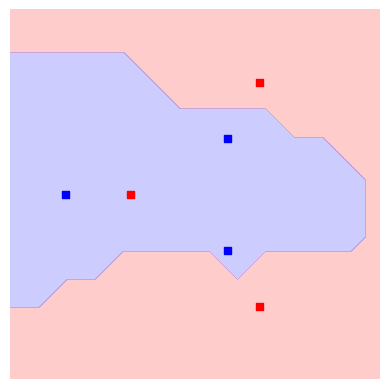

In [18]:
init_plot_data = plot_decision_boundaries(svm, plt.gca())

We see the outer points in the dataset can be correctly classified, but we still struggle with the inner circle. But remember we have a circuit
with many free parameters! It is reasonable to believe we can give values to those variational parameters which improve the overall accuracy of our SVC.

## Training the Quantum Embedding Kernel


To be able to train the Quantum Embedding Kernel we need some measure of how well it fits the dataset in question. Performing an exhaustive search in parameter space is not a good solution because it is very
resource intensive, and since the accuracy is a discrete quantity we would not be able to detect small improvements.

We can, however, resort to a more specialized measure, the *kernel-target alignment*. The kernel-target alignment compares the similarity predicted by the quantum kernel to the actual labels of the training data. It is based on *kernel alignment*, a similiarity measure between two kernels with given kernel matrices $K_1$ and $K_2$:

$$\operatorname{KA}(K_1, K_2) = \frac{\operatorname{Tr}(K_1 K_2)}{\sqrt{\operatorname{Tr}(K_1^2)\operatorname{Tr}(K_2^2)}}.$$

Note

Seen from a more theoretical side, $\operatorname{KA}$ is nothing else than the cosine of the angle between the kernel matrices $K_1$ and $K_2$
if we see them as vectors in the space of matrices with the Hilbert-Schmidt (or Frobenius) scalar product $\langle A, B \rangle = \operatorname{Tr}(A^T B)$. This reinforces the
geometric picture of how this measure relates to objects, namely two kernels, being aligned in a vector space.

The training data enters the picture by defining an *ideal* kernel function that expresses the original labelling in the vector $\boldsymbol{y}$ by assigning to two datapoints the product of the
corresponding labels:

$$k_{\boldsymbol{y}}(\boldsymbol{x}_i, \boldsymbol{x}_j) = y_i y_j.$$

The assigned kernel is thus $+1$ if both datapoints lie in the same
class and $-1$ otherwise and its kernel matrix is simply given by the
outer product $\boldsymbol{y}\boldsymbol{y}^T$. The kernel-target
alignment is then defined as the kernel alignment of the kernel matrix
$K$ generated by the quantum kernel and
$\boldsymbol{y}\boldsymbol{y}^T$:

$$\operatorname{KTA}_{\boldsymbol{y}}(K)
= \frac{\operatorname{Tr}(K \boldsymbol{y}\boldsymbol{y}^T)}{\sqrt{\operatorname{Tr}(K^2)\operatorname{Tr}((\boldsymbol{y}\boldsymbol{y}^T)^2)}}
= \frac{\boldsymbol{y}^T K \boldsymbol{y}}{\sqrt{\operatorname{Tr}(K^2)} N}$$

where $N$ is the number of elements in $\boldsymbol{y}$, that is the
number of datapoints in the dataset.

In summary, the kernel-target alignment effectively captures how well
the kernel you chose reproduces the actual similarities of the data. It
does have one drawback, however: having a high kernel-target alignment
is only a necessary but not a sufficient condition for a good
performance of the kernel. This means having good alignment is
guaranteed for good performance, but optimal alignment will not always
bring optimal training accuracy with it.

Let\'s now come back to the actual implementation. PennyLane\'s
`kernels` module allows you to easily evaluate the kernel target
alignment:


In [19]:
kta_init = qml.kernels.target_alignment(X, Y, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init:.3f}")

The kernel-target alignment for our dataset and random parameters is 0.081


Now let\'s code up an optimization loop and improve the kernel-target
alignment!

We will make use of regular gradient descent optimization. To speed up
the optimization we will not use the entire training set to compute
$\operatorname{KTA}$ but rather sample smaller subsets of the data at
each step, we choose $4$ datapoints at random. Remember that
PennyLane\'s built-in optimizer works to *minimize* the cost function
that is given to it, which is why we have to multiply the kernel target
alignment by $-1$ to actually *maximize* it in the process.


Note

Currently, the function `qml.kernels.target_alignment` is not
differentiable yet, making it unfit for gradient descent optimization.
We therefore first define a differentiable version of this function.


In [20]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(0.2)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(X))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        X[subset],
        Y[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            X,
            Y,
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

Step 50 - Alignment = 0.098
Step 100 - Alignment = 0.121
Step 150 - Alignment = 0.141
Step 200 - Alignment = 0.173
Step 250 - Alignment = 0.196
Step 300 - Alignment = 0.224
Step 350 - Alignment = 0.245
Step 400 - Alignment = 0.261
Step 450 - Alignment = 0.276
Step 500 - Alignment = 0.289


We want to assess the impact of training the parameters of the quantum
kernel. Thus, let\'s build a second support vector classifier with the
trained kernel:


In [21]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X, Y)

We expect to see an accuracy improvement vs. the SVM with random
parameters:


In [22]:
accuracy_trained = accuracy(svm_trained, X, Y)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

The accuracy of a kernel with trained parameters is 1.000


We have now achieved perfect classification!

Following on the results that SVM\'s have proven good generalisation
behavior, it will be interesting to inspect the decision boundaries of
our classifier:


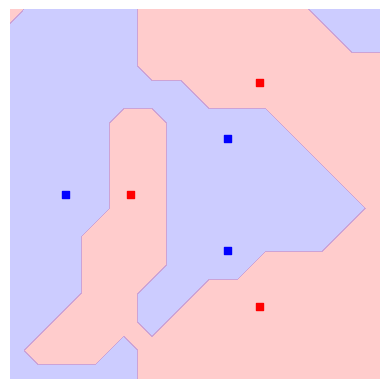

In [23]:
trained_plot_data = plot_decision_boundaries(svm_trained, plt.gca())

Indeed, we see that now not only every data instance falls within the
correct class, but also that there are no strong artifacts that would
make us distrust the model. In this sense, our approach benefits from
both: on one hand it can adjust itself to the dataset, and on the other
hand is not expected to suffer from bad generalisation.


# How to approximate a classical kernel with a quantum computer


Forget about advantages, supremacies, or speed-ups. Let us understand better what we can and cannot do with a quantum computer. More specifically, in this demo, we want to look into quantum kernels and ask whether we can replicate classical kernel functions with a quantum  computer. Lots of researchers have lengthily stared at the opposite question, namely that of classical simulation of quantum algorithms. Yet, by studying what classes of functions we can realize with quantum kernels, we can gain some insight into their inner workings.

Usually, in quantum machine learning (QML), we use parametrized quantum circuits (PQCs) to find good functions, whatever *good* means here. Since kernels are just one specific kind of well-defined functions, the task of finding a quantum kernel (QK) that approximates a given classical one could be posed as an optimization problem. One way to attack this task is to define a loss function quantifying the distance between both functions (the classical kernel function and the PQC-based hypothesis). This sort of approach does not help us much to gain theoretical insights about the structure of kernel-emulating quantum circuits, though.

In order to build intuition, we will instead study the link between classical and quantum kernels through the lens of the Fourier representation of a kernel, which is a common tool in classical machine learning. Two functions can only have the same Fourier spectrum if they are the same function. It turns out that, for certain classes of quantum circuits, [we can theoretically describe the Fourier spectrum rather well](https://pennylane.ai/qml/demos/tutorial_expressivity_fourier_series.html).

Using this theory, together with some good old-fashioned convex optimization, we will derive a quantum circuit that approximates the famous Gaussian kernel.

In order to keep the demo short and sweet, we focus on one simple example. The same ideas apply to more general scenarios. So tag along if you\'d like to see how we build
a quantum kernel that approximates the well-known Gaussian kernel function!

| 

![Schematic of the steps covered in this
demo.](images/classical_kernels_flowchart.PNG)

## Kernel-based Machine Learning


For the purposes of this demo, a *kernel* is a real-valued function of two variables $k(x_1,x_2)$ from a given data domain $x_1, x_2\in\mathcal{X}$. In this demo, we\'ll deal with real vector spaces as the data domain $\mathcal{X}\subseteq\mathbb{R}^d$, of some dimension $d$. A kernel has to be symmetric with respect to exchanging both variables $k(x_1,x_2) = k(x_2,x_1)$. We also enforce kernels to be positive semi-definite, but let\'s avoid getting lost in mathematical lingo. You can trust that all kernels featured in this demo are positive semi-definite.

## Shift-invariant kernels

Some kernels fulfill another important restriction, called *shift-invariance*. Shift-invariant kernels are those whose value doesn\'t change if we add a shift to both inputs. Explicitly, for any suitable shift vector $\zeta\in\mathcal{X}$, shift-invariant kernels are those for which $k(x_1+\zeta,x_2+\zeta)=k(x_1,x_2)$ holds. Having this property means the function can be written in terms of only one variable, which we call the *lag vector* $\delta:=x_1-x_2\in\mathcal{X}$. Abusing notation a bit:

$$k(x_1,x_2)=k(x_1-x_2,0) = k(\delta).$$

For shift-invariant kernels, the exchange symmetry property $k(x_1,x_2)=k(x_2,x_1)$ translates into reflection symmetry$k(\delta)=k(-\delta)$. Accordingly, we say $k$ is an *even function*.

## Warm up: Implementing the Gaussian kernel

First, let\'s introduce a simple classical kernel that we will approximate on the quantum computer. Start importing the usual suspects:

In [24]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(53173)

We\'ll look at the Gaussian kernel:
$k_\sigma(x_1,x_2):=e^{-\lVert x_1-x_2\rVert^2/2\sigma^2}$. This
function is clearly shift-invariant:

$$\begin{aligned}
k_\sigma(x_1+\zeta,x_2+\zeta) &= e^{-\lVert(x_1+\zeta)-(x_2+\zeta)\rVert^2/2\sigma^2} \\
& = e^{-\lVert x_1-x_2\rVert^2/2\sigma^2} \\
& = k_\sigma(x_1,x_2).
\end{aligned}$$

The object of our study will be a simple version of the Gaussian kernel, where we consider $1$-dimensional data, so $\lVert x_1-x_2\rVert^2=(x_1-x_2)^2$. Also, we take $\sigma=1/\sqrt{2}$ so that we further simplify the exponent. We can always re-introduce it later by rescaling the data. Again, we can write the function in terms of the lag vector only:

$$k(\delta)=e^{-\delta^2}.$$

Now let\'s write a few lines to plot the Gaussian kernel:


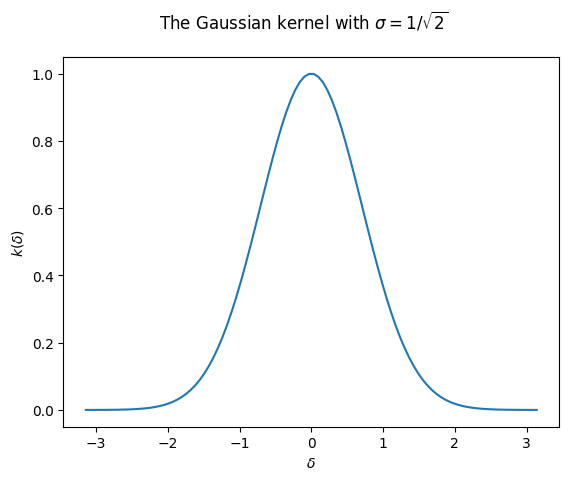

In [25]:
def gaussian_kernel(delta):
    return math.exp(-delta ** 2)

def make_data(n_samples, lower=-np.pi, higher=np.pi):
    x = np.linspace(lower, higher, n_samples)
    y = np.array([gaussian_kernel(x_) for x_ in x])
    return x,y

X, Y_gaussian = make_data(100)

plt.plot(X, Y_gaussian)
plt.suptitle("The Gaussian kernel with $\sigma=1/\sqrt{2}$")
plt.xlabel("$\delta$")
plt.ylabel("$k(\delta)$")
plt.show();

In this demo, we will consider only this one example. However, the
arguments we make and the code we use are also amenable to any kernel
with the following mild restrictions:

1.  Shift-invariance
2.  Normalization $k(0)=1$.
3.  Smoothness (in the sense of a quickly decaying Fourier spectrum).

Note that is a very large class of kernels! And also an important one
for practical applications.

## Fourier analysis of the Gaussian kernel

The next step will be to find the Fourier spectrum of the Gaussian kernel, which is an easy problem for classical computers. Once we\'ve found it, we\'ll build a QK that produces a finite Fourier series approximation to that spectrum.

Let\'s briefly recall that a Fourier series is the representation of a periodic function using the sine and cosine functions. Fourier analysis tells us that we can write any given periodic function as

$$f(x) = a_0 + \sum_{n=1}^\infty a_n\cos(n\omega_0x) + b_n\sin(n\omega_0x).$$

For that, we only need to find the suitable base frequency $\omega_0$ and coefficients $a_0, a_1, \ldots, b_0, b_1,\ldots$.

But the Gaussian kernel is an aperiodic function, whereas the Fourier series only makes sense for periodic functions!

*What can we do?!*

We can cook up a periodic extension to the Gaussian kernel, for a given period $2L$ (we take $L=\pi$ as default):


In [26]:
def Gauss_p(x, L=np.pi):
    # Send x to x_mod in the period around 0
    x_mod = np.mod(x+L, 2*L) - L
    return gaussian_kernel(x_mod)

which we can now plot


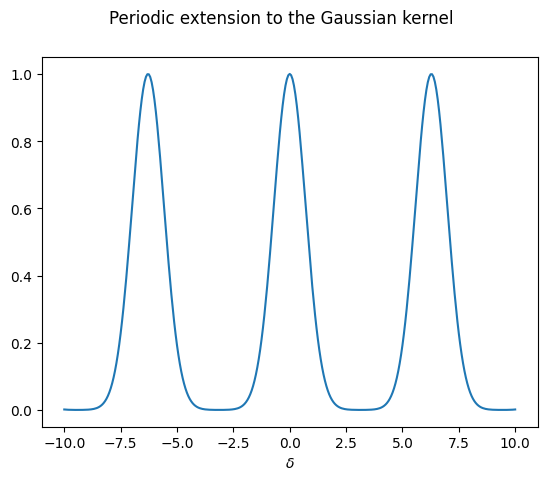

In [27]:
x_func = np.linspace(-10, 10, 321)
y_func = [Gauss_p(x) for x in x_func]

plt.plot(x_func, y_func)
plt.xlabel("$\delta$")
plt.suptitle("Periodic extension to the Gaussian kernel")
plt.show();

In practice, we would construct several periodic extensions of the aperiodic function, with increasing periods. This way, we can study the behaviour when the period approaches infinity, i.e. the regime where the function stops being periodic.

Next up, how does the Fourier spectrum of such an object look like? We can find out using PennyLane\'s `fourier` module!


In [28]:
from pennylane.fourier import coefficients

The function `coefficients` computes for us the coefficients of the Fourier series up to a fixed term. One tiny detail here: `coefficients` returns one complex number $c_n$ for each frequency $n$. The real part corresponds to the $a_n$ coefficient, and the imaginary part to the $b_n$ coefficient: $c_n=a_n+ib_n$. Because the Gaussian kernel is an even function, we know that the imaginary part of every coefficient will be zero, so $c_n=a_n$.


In [29]:
def fourier_p(d):
    """
    We only take the first d coefficients [:d]
    because coefficients() treats the negative frequencies
    as different from the positive ones.
    For real functions, they are the same.
    """
    return np.real(coefficients(Gauss_p, 1, d-1)[:d])

We are restricted to considering only a finite number of Fourier terms. But isn\'t that problematic, one may say? Well, maybe. Since we know the Gaussian kernel is a smooth function, we expect that the coefficients
converge to $0$ at some point, and we will only need to consider terms up to this point. Let\'s look at the coefficients we obtain by setting a low value for the number of coefficients and then slowly letting it grow:


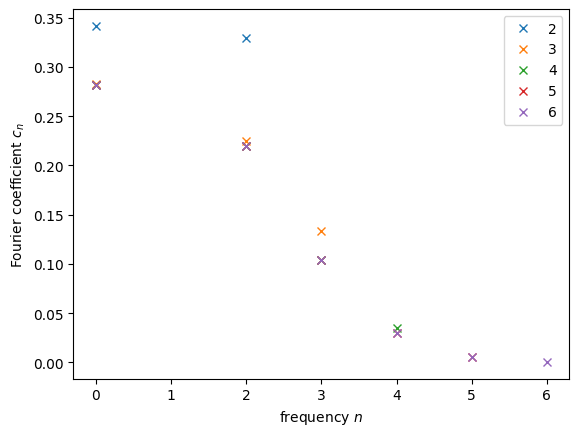

In [30]:
N = [0]
for n in range(2,7):
    N.append(n)
    F = fourier_p(n)
    plt.plot(N, F, 'x', label='{}'.format(n))

plt.legend()
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient $c_n$")
plt.show();

What do we see? For very small coefficient counts, like $2$ and $3$, we see that the last allowed coefficient is still far from $0$. That\'s a very clear indicator that we need to consider more frequencies. At the same time, it seems like starting at $5$ or $6$ all the non-zero contributions have already been well captured. This is important for us, since it tells us the minimum number of qubits we should use. One can see that every new qubit doubles the number of frequencies we can use, so for $n$ qubits, we will have $2^n$. At minimum of $6$ frequencies means at least $3$ qubits, corresponding to $2^3=8$ frequencies. As we\'ll see later, we\'ll work with $5$ qubits, so $32$ frequencies. That means the spectrum we will be trying to replicate will be the following:

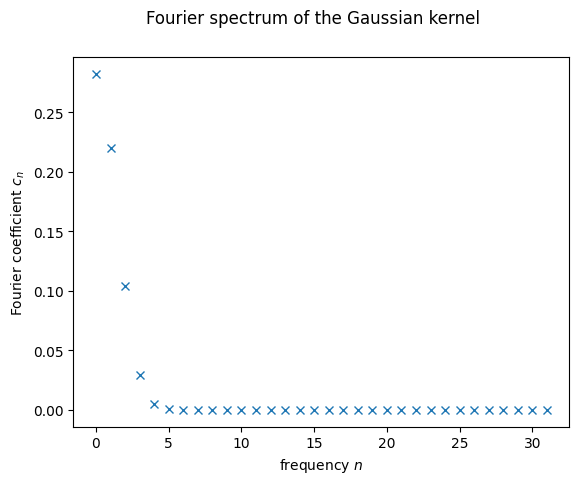

In [31]:
plt.plot(range(32), fourier_p(32), 'x')
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient $c_n$")
plt.suptitle("Fourier spectrum of the Gaussian kernel")
plt.show();

We just need a QK with the same Fourier spectrum!

## Designing a suitable QK


Designing a suitable QK amounts to designing a suitable parametrized quantum circuit. Let\'s take a moment to refresh the big scheme of things with the following picture:

![The quantum kernel considered in this demo.](images/QEK.jpg)

We construct the quantum kernel from a quantum embedding. The quantum embedding circuit will consist of two parts. The first one, trainable, will be a parametrized general state preparation scheme $W_a$, with parameters $a$. In the second one, we input the data, denoted by $S(x)$.

Start with the non-trainable gate we\'ll use to encode the data $S(x)$. It consists of applying one Pauli-$Z$ rotation to each qubit with rotation parameter $x$ times some constant $\vartheta_i$, for the $i^\text{th}$ qubit.


In [32]:
def S(x, thetas, wires):
    for (i, wire) in enumerate(wires):
        qml.RZ(thetas[i] * x, wires = [wire])

By setting the `thetas` properly, we achieve the integer-valued spectrum, as required by the Fourier series expansion of a function of period $2\pi$: $\{0, 1, \ldots, 2^n-2, 2^n-1\}$, for $n$ qubits. Some math shows that setting $\vartheta_i=2^{n-i}$, for $\{1,\ldots,n\}$ produces the desired outcome.


In [33]:
def make_thetas(n_wires):
    return [2 ** i for i in range(n_wires-1, -1, -1)]

Next, we introduce the only trainable gate we need to make use of. Contrary to the usual Ansätze used in supervised and unsupervised learning, we use a state preparation template called `MottonenStatePreparation`. This is one option for amplitude encoding already implemented in PennyLane, so we don\'t need to code it ourselves. Amplitude encoding is a common way of embedding classical data into a quantum system in QML. The unitary associated to this
template transforms the $\lvert0\rangle$ state into a state with amplitudes $a=(a_0,a_1,\ldots,a_{2^n-1})$, namely $\lvert a\rangle=\sum_j a_j\lvert j\rangle$, provided $\lVert a\rVert^2=1$.


In [34]:
def W(features, wires):
    qml.templates.state_preparations.MottonenStatePreparation(features, wires)

With that, we have the feature map onto the Hilbert space of the quantum computer:

$$\lvert x_a\rangle = S(x)W_a\lvert0\rangle,$$

for a given $a$, which we will specify later.

Accordingly, we can build the QK corresponding to this feature map as

$$\begin{aligned}
k_a(x_1,x_2) &= \lvert\langle0\rvert W_a^\dagger S^\dagger(x_1)
S(x_2)W_a\lvert0\rangle\rvert^2 \\
&= \lvert\langle0\rvert W_a^\dagger S(x_2-x_1) W_a\lvert0\rangle\rvert^2.
\end{aligned}$$

In the code below, the variable `amplitudes` corresponds to our set $a$.


In [35]:
def ansatz(x1, x2, thetas, amplitudes, wires):
    W(amplitudes, wires)
    S(x1 - x2, thetas, wires)
    qml.adjoint(W)(amplitudes, wires)

Since this kernel is by construction real-valued, we also have

$$\begin{aligned}
(k_a(x_1,x_2))^\ast &= k_a(x_1,x_2) \\
&= \lvert\langle0\rvert W_a^\dagger S(x_1-x_2) W_a\lvert0\rangle\rvert^2 \\
&= k_a(x_2,x_1).
\end{aligned}$$

Further, this QK is also shift-invariant $k_a(x_1,x_2) = k_a(x_1+\zeta,
x_2+\zeta)$ for any $\zeta\in\mathbb{R}$. So we can also write it in
terms of the lag $\delta=x_1-x_2$:

$$k_a(\delta) = \lvert\langle0\rvert W_a^\dagger
S(\delta)W_a\lvert0\rangle\rvert^2.$$

So far, we only wrote the gate layout for the quantum circuit, no measurement! We need a few more functions for that!

## Computing the QK function on a quantum device


Also, at this point, we need to set the number of qubits of our computer. For this example, we\'ll use the variable `n_wires`, and set it to $5$.


In [36]:
n_wires = 5

We initialize the quantum simulator:


In [37]:
dev = qml.device("default.qubit", wires = n_wires, shots = None)

Next, we construct the quantum node:


In [38]:
@qml.qnode(dev)
def QK_circuit(x1, x2, thetas, amplitudes):
    ansatz(x1, x2, thetas, amplitudes, wires = range(n_wires))
    return qml.probs(wires = range(n_wires))

Recall that the output of a QK is defined as the probability of
obtaining the outcome $\lvert0\rangle$ when measuring in the
computational basis. That corresponds to the $0^\text{th}$ entry of
`qml.probs`:


In [39]:
def QK_2(x1, x2, thetas, amplitudes):
    return QK_circuit(x1, x2, thetas, amplitudes)[0]

As a couple of quality-of-life improvements, we write a function that
implements the QK with the lag $\delta$ as its argument, and one that
implements it on a given set of data:


In [40]:
def QK(delta, thetas, amplitudes):
    return QK_2(delta, 0, thetas, amplitudes)

def QK_on_dataset(deltas, thetas, amplitudes):
    y = np.array([QK(delta, thetas, amplitudes) for delta in deltas])
    return y

This is also a good place to fix the `thetas` array, so that we don\'t
forget later.


In [41]:
thetas = make_thetas(n_wires)

Let\'s see how this looks like for one particular choice of
`amplitudes`. We need to make sure the array fulfills the normalization
conditions.


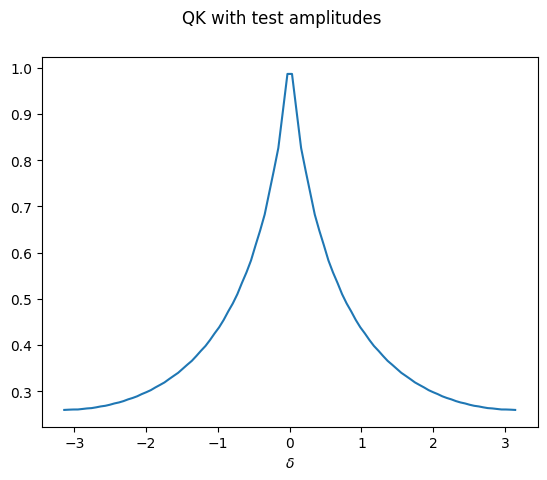

In [42]:
test_features = np.asarray([1./(1+i) for i in range(2 ** n_wires)])
test_amplitudes = test_features / np.sqrt(np.sum(test_features ** 2))

Y_test = QK_on_dataset(X, thetas, test_amplitudes)

plt.plot(X, Y_test)
plt.xlabel("$\delta$")
plt.suptitle("QK with test amplitudes")
plt.show();

One can see that the stationary kernel with this particular initial state has a decaying spectrum that looks similar to $1/\lvert x\rvert$ --- but not yet like a Gaussian.

## How to find the amplitudes emulating a Gaussian kernel


If we knew exactly which amplitudes to choose in order to build a given Fourier spectrum, our job would be done here. However, the equations derived in the literature are not trivial to solve.

As mentioned in the introduction, one could just \"learn\" this relation, that is, tune the parameters of the quantum kernel in a gradient-based manner until it matches the classical one.

We want to take an intermediate route between analytical solution and black-box optimization. For that, we derive an equation that links the amplitudes to the spectrum we want to construct and then use
old-fashioned convex optimization to find the solution. If you are not interested in the details, you can just jump to the last plots of this demo and confirm that we can to emulate the Gaussian kernel using the ansatz for our QK constructed above.

In order to simplify the formulas, we introduce new variables, which we call `probabilities` $(p_0, p_1, p_2, \ldots, p_{2^n-1})$, and we define as $p_j=\lvert a_j\rvert^2$. Following the normalization property above, we have $\sum_j p_j=1$. Don\'t get too fond of them, we only need them for this step! Remember we introduced the vector $a$ for the `MottonenStatePreparation` as the *amplitudes* of a quantum state? Then it makes sense that we call its squares *probabilities*, doesn\'t it?

There is a crazy formula that matches the entries of *probabilities* with the Fourier series of the resulting QK function:

$$\begin{aligned}
\text{probabilities} &\longrightarrow \text{Fourier coefficients} \\
\begin{pmatrix} p_0 \\ p_1 \\ p_2 \\ \vdots \\ p_{2^n-1} \end{pmatrix}
&\longmapsto \begin{pmatrix} \sum_{j=0}^{2^n-1} p_j^2 \\ \sum_{j=1}^{2^n-1}
p_j p_{j-1} \\ \sum_{j=2}^{2^n-1} p_j p_{j-2} \\ \vdots \\ p_{2^n-1} p_0
\end{pmatrix}
\end{aligned}$$

This looks a bit scary, it follows from expanding the matrix product $W_a^\dagger S(\delta)W_a$, and then collecting terms according to Fourier basis monomials. In this sense, the formula is general and it applies to any shift-invariant kernel we might want to approximate, not only the Gaussian kernel.

Our goal is to find the set of $p_j$\'s that produces the Fourier coefficients of a given kernel function (in our case, the Gaussian kernel), namely its spectrum $(s_0, s_1, s_2, \ldots, s_{2^n-1})$. We consider now a slightly different map $F_s$, for a given spectrum $(s_0, s_1, \ldots, s_{2^n-1})$:

$$\begin{aligned}
F_s: \text{probabilities} &\longrightarrow \text{Difference between Fourier
coefficients} \\
\begin{pmatrix} p_0 \\ p_1 \\ p_2 \\ \vdots \\ p_{2^n-1} \end{pmatrix}
&\longmapsto \begin{pmatrix} \sum_{j=0}^{2^n-1} p_j^2 - s_0 \\
\sum_{j=1}^{2^n-1} p_j p_{j-1} - s_1 \\ \sum_{j=2}^{2^n-1} p_j
p_{j-2} - s_2 \\ \vdots \\ p_{2^n-1}p_0 - s_{2^n-1} \end{pmatrix}.
\end{aligned}$$

If you look at it again, you\'ll see that the zero (or solution) of this second map $F_s$ is precisely the array of *probabilities* we are looking for. We can write down the first map as:


In [43]:
def predict_spectrum(probabilities):
    d = len(probabilities)
    spectrum = []
    for s in range(d):
        s_ = 0

        for j in range(s, d):
            s_ += probabilities[j] * probabilities[j - s]

        spectrum.append(s_)

    # This is to make the output have the same format as
    # the output of pennylane.fourier.coefficients
    for s in range(1,d):
        spectrum.append(spectrum[d - s])

    return spectrum

And then $F_s$ is just `predict_spectrum` minus the spectrum we want to predict:


In [44]:
def F(probabilities, spectrum):
    d = len(probabilities)
    return predict_spectrum(probabilities)[:d] - spectrum[:d]

These closed-form equations allow us to find the solution numerically, using Newton\'s method! Newton\'s method is a classical one from convex optimization theory. For our case, since the formula is quadratic, we rest assured that we are within the realm of convex functions.

## Finding the solution

In order to use Newton\'s method we need the Jacobian of $F_s$.


In [45]:
def J_F(probabilities):
    d = len(probabilities)
    J = np.zeros(shape=(d,d))
    for i in range(d):
        for j in range(d):
            if (i + j < d):
                J[i][j] += probabilities[i + j]
            if(i - j <= 0):
                J[i][j] += probabilities[j - i]
    return J

Showing that this is indeed $\nabla F_s$ is left as an exercise for the reader. For Newton\'s method, we also need an initial guess. Finding a
good initial guess requires some tinkering; different problems will benefit from different ones. Here is a tame one that works for the Gaussian kernel.


In [46]:
def make_initial_probabilities(d):
    probabilities = np.ones(d)
    deg = np.array(range(1, d + 1))
    probabilities = probabilities / deg
    return probabilities

probabilities = make_initial_probabilities(2 ** n_wires)

Recall the `spectrum` we want to match is that of the periodic extension of the Gaussian kernel.


In [47]:
spectrum = fourier_p(2 ** n_wires)

We fix the hyperparameters for Newton\'s method:


In [48]:
d = 2 ** n_wires
max_steps = 100
tol = 1.e-20

And we\'re good to go!


In [49]:
for step in range(max_steps):
    inc = np.linalg.solve(J_F(probabilities), -F(probabilities, spectrum))
    probabilities = probabilities + inc
    if (step+1) % 10 == 0:
        print("Error norm at step {0:3}: {1}".format(step + 1,
                                               np.linalg.norm(F(probabilities,
                                                                spectrum))))
        if np.linalg.norm(F(probabilities, spectrum)) < tol:
            print("Tolerance trespassed! This is the end.")
            break

Error norm at step  10: 7.231526379770506e-14
Error norm at step  20: 5.551115536294438e-17
Error norm at step  30: 9.2815769223824e-21
Tolerance trespassed! This is the end.


The tolerance we set was fairly low, one should expect good things to
come out of this. Let\'s have a look at the solution:


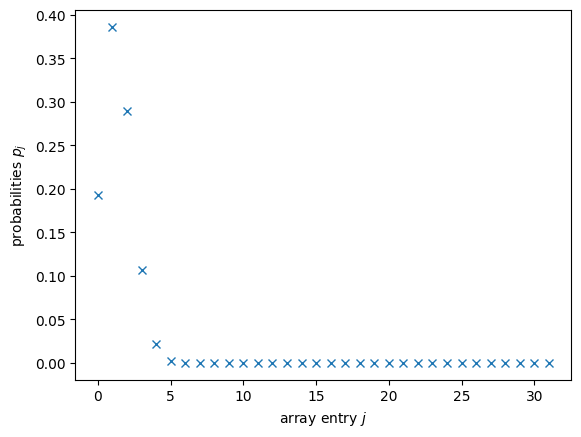

In [50]:
plt.plot(range(d), probabilities, 'x')
plt.xlabel("array entry $j$")
plt.ylabel("probabilities $p_j$")
plt.show();

Would you be able to tell whether this is correct? Me neither! But all those probabilities being close to $0$ should make us fear some of them must\'ve turned negative. That would be fatal for us. For `MottonenStatePreparation`, we\'ll need to give `amplitudes` as one of the arguments, which is the component-wise square root of `probabilities`. And hence the problem! Even if they are very small values, if any entry of `probabilities` is negative, the square root will give `nan`. In order to avoid that, we use a simple thresholding where we replace very small entries by $0$.


In [51]:
def probabilities_threshold_normalize(probabilities, thresh = 1.e-10):
    d = len(probabilities)
    p_t = probabilities.copy()
    for i in range(d):
        if np.abs(probabilities[i] < thresh):
            p_t[i] = 0.0

    p_t = p_t / np.sum(p_t)

    return p_t

Then, we need to take the square root:


In [52]:
probabilities = probabilities_threshold_normalize(probabilities)
amplitudes = np.sqrt(probabilities)

A little plotting never killed nobody


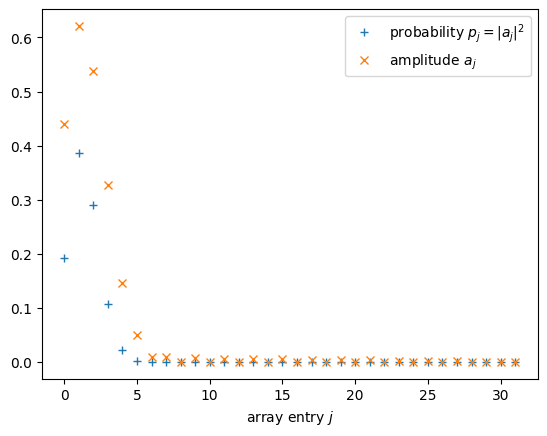

In [53]:
plt.plot(range(d), probabilities, '+', label = "probability $p_j = |a_j|^2$")
plt.plot(range(d), amplitudes, 'x', label = "amplitude $a_j$")
plt.xlabel("array entry $j$")
plt.legend()
plt.show();

## Visualizing the solution

And the moment of truth! Does the solution really match the spectrum? We try it first using `predict_spectrum` only


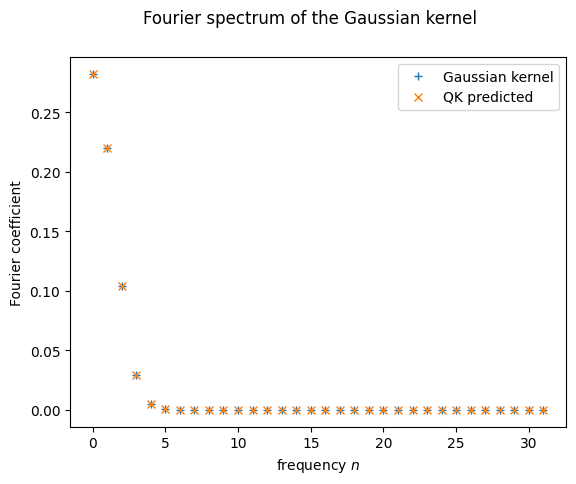

In [54]:
plt.plot(range(d), fourier_p(d)[:d], '+', label = "Gaussian kernel")
plt.plot(range(d), predict_spectrum(probabilities)[:d], 'x', label = "QK predicted")
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient")
plt.suptitle("Fourier spectrum of the Gaussian kernel")
plt.legend()
plt.show();

It seems like it does! But as we just said, this is still only the predicted spectrum. We haven\'t called the quantum computer at all yet!

Let\'s see what happens when we call the function `coefficients` on the QK function we defined earlier. Good coding practice tells us we should probably turn this step into a function itself, in case it is of use later:


In [55]:
def fourier_q(d, thetas, amplitudes):
    return np.real(coefficients(lambda x: QK(x, thetas, amplitudes), 1, d-1))

And with this, we can finally visualize how the Fourier spectrum of the QK function compares to that of the Gaussian kernel:


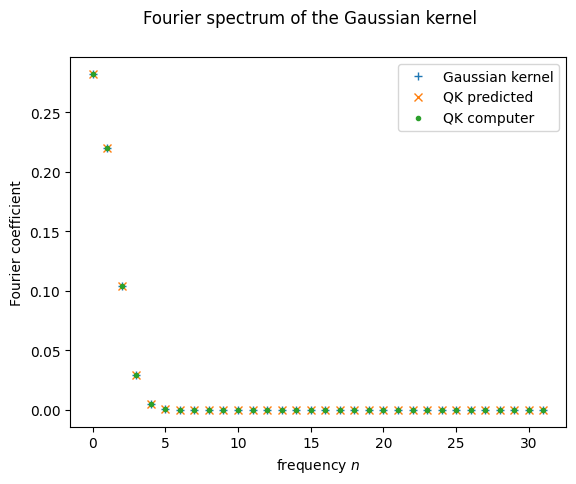

In [56]:
plt.plot(range(d), fourier_p(d)[:d], '+', label = "Gaussian kernel")
plt.plot(range(d), predict_spectrum(probabilities)[:d], 'x', label="QK predicted")
plt.plot(range(d), fourier_q(d, thetas, amplitudes)[:d], '.', label = "QK computer")
plt.xlabel("frequency $n$")
plt.ylabel("Fourier coefficient")
plt.suptitle("Fourier spectrum of the Gaussian kernel")
plt.legend()
plt.show();

It seems it went well! Matching spectra should mean matching kernel functions, right?


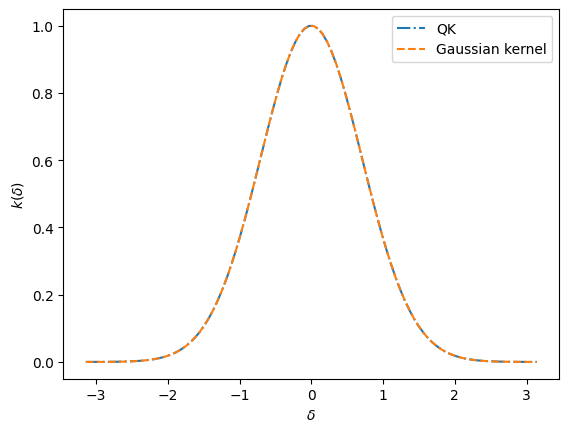

In [57]:
Y_learned = QK_on_dataset(X, thetas, amplitudes)
Y_truth = [Gauss_p(x_) for x_ in X]

plt.plot(X, Y_learned, '-.', label = "QK")
plt.plot(X, Y_truth, '--', label = "Gaussian kernel")
plt.xlabel("$\delta$")
plt.ylabel("$k(\delta)$")
plt.legend()
plt.show();

Yeah! We did it!

![](images/salesman.PNG)


# Kernel-based training of quantum models with scikit-learn


Over the last few years, quantum machine learning research has provided a lot of insights on how we can understand and train quantum circuits as machine learning models. While many connections to neural networks have been made, it becomes increasingly clear that their mathematical foundation is intimately related to so-called *kernel methods*, the most famous of which is the [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) (see for example [Schuld and Killoran (2018)](https://arxiv.org/abs/1803.07128), [Havlicek et al. (2018)](https://arxiv.org/abs/1804.11326), [Liu et al. (2020)](https://arxiv.org/abs/2010.02174), [Huang et al. (2020)](https://arxiv.org/pdf/2011.01938), and, for a systematic summary which we will follow here, [Schuld (2021)](https://arxiv.org/abs/2101.11020)).

The link between quantum models and kernel methods has important practical implications: we can replace the common [variational approach](https://pennylane.ai/qml/glossary/variational_circuit.html) to quantum machine learning with a classical kernel method where the kernel---a small building block of the overall algorithm---is computed by a quantum device. In many situations there are guarantees that we get better or at least equally good results.

This demonstration explores how kernel-based training compares with [variational training](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) in terms of the number of quantum circuits that have to be evaluated.
For this we train a quantum machine learning model with a kernel-based approach using a combination of PennyLane and the [scikit-learn](https://scikit-learn.org/) machine learning library. We compare this strategy with a variational quantum circuit trained via stochastic gradient descent using [PyTorch](https://pennylane.readthedocs.io/en/stable/introduction/interfaces/torch.html).

We will see that in a typical small-scale example, kernel-based training requires only a fraction of the number of quantum circuit evaluations used by variational circuit training, while each evaluation runs a much shorter circuit. In general, the relative efficiency of kernel-based methods compared to variational circuits depends on the number of parameters used in the variational model.

![](images/scaling.png)

If the number of variational parameters remains small, e.g., there is a square-root-like scaling with the number of data samples (green line), variational circuits are almost as efficient as neural networks (blue line), and require much fewer circuit evaluations than the quadratic scaling of kernel methods (red line). However, with current hardware-compatible training strategies, kernel methods scale much better than variational circuits that require a number of parameters of the order of the training set size (orange line).

In conclusion, **for quantum machine learning applications with many parameters, kernel-based training can be a great alternative to the variational approach to quantum machine learning**.

After working through this demo, you will:

-   be able to use a support vector machine with a quantum kernel
    computed with PennyLane, and
-   be able to compare the scaling of quantum circuit evaluations
    required in kernel-based versus variational training.


## Background


Let us consider a *quantum model* of the form

$$f(x) = \langle \phi(x) | \mathcal{M} | \phi(x)\rangle,$$

where $| \phi(x)\rangle$ is prepared by a fixed [embedding circuit](https://pennylane.ai/qml/glossary/quantum_embedding.html) that encodes data inputs $x$, and $\mathcal{M}$ is an arbitrary observable.
This model includes variational quantum machine learning models, since the observable can effectively be implemented by a simple measurement that is preceded by a variational circuit:

![](images/quantum_model.png)

For example, applying a circuit $G(\theta)$ and then measuring the Pauli-Z observable $\sigma^0_z$ of the first qubit implements the trainable measurement $\mathcal{M}(\theta) = G^{\dagger}(\theta) \sigma^0_z G(\theta)$.

The main practical consequence of approaching quantum machine learning with a kernel approach is that instead of training $f$ variationally, we can often train an equivalent classical kernel method with a kernel
executed on a quantum device. This *quantum kernel* is given by the mutual overlap of two data-encoding quantum states,

$$\kappa(x, x') = | \langle \phi(x') | \phi(x)\rangle|^2.$$

Kernel-based training therefore bypasses the processing and measurement parts of common variational circuits, and only depends on the data encoding.

If the loss function $L$ is the [hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), the kernel method corresponds to a standard [support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine) (SVM) in
the sense of a maximum-margin classifier. Other convex loss functions lead to more general variations of support vector machines.

Note:

More precisely, we can replace variational with kernel-based training if
the optimisation problem can be written as minimizing a cost of the form

$$\min_f  \lambda\;  \mathrm{tr}\{\mathcal{M}^2\} + \frac{1}{M}\sum_{m=1}^M L(f(x^m), y^m),$$

which is a regularized empirical risk with training data samples
$(x^m, y^m)_{m=1\dots M}$, regularization strength
$\lambda \in \mathbb{R}$, and loss function $L$.

Theory predicts that kernel-based training will always find better or
equally good minima of this risk. However, to show this here we would
have to either regularize the variational training by the trace of the
squared observable, or switch off regularization in the classical SVM,
which removes a lot of its strength. The kernel-based and the
variational training in this demonstration therefore optimize slightly
different cost functions, and it is out of our scope to establish
whether one training method finds a better minimum than the other.



## Kernel-based training


First, we will turn to kernel-based training of quantum models. As stated above, an example implementation is a standard support vector machine with a kernel computed by a quantum circuit.


We begin by importing all sorts of useful methods:


In [58]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

ModuleNotFoundError: No module named 'torch'

The second step is to define a data set. Since the performance of the models is not the focus of this demo, we can just use the first two classes of the famous [Iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set). Dating back to as far as 1936, this toy data set consists of 100 samples of four features each, and gives rise to a very simple classification problem.


In [ ]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

We use the [angle-embedding template](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.embeddings.AngleEmbedding.html) which needs as many qubits as there are features:


In [ ]:
n_qubits = len(X_train[0])
n_qubits

To implement the kernel we could prepare the two states $| \phi(x) \rangle$, $| \phi(x') \rangle$ on different sets of qubits with angle-embedding routines $S(x), S(x')$, and measure their overlap
with a small routine called a [SWAP test](https://en.wikipedia.org/wiki/Swap_test).

However, we need only half the number of qubits if we prepare $| \phi(x)\rangle$ and then apply the inverse embedding with $x'$ on the same qubits. We then measure the projector onto the initial state
$|0..0\rangle \langle 0..0|$.

![](images/kernel_circuit.png){.align-center}

To verify that this gives us the kernel:

$$\begin{aligned}
\begin{align*}
    \langle 0..0 |S(x') S(x)^{\dagger} \mathcal{M} S(x')^{\dagger} S(x)  | 0..0\rangle &= \langle 0..0 |S(x') S(x)^{\dagger} |0..0\rangle \langle 0..0| S(x')^{\dagger} S(x)  | 0..0\rangle  \\
    &= |\langle 0..0| S(x')^{\dagger} S(x)  | 0..0\rangle |^2\\
    &= | \langle \phi(x') | \phi(x)\rangle|^2 \\
    &= \kappa(x, x').
\end{align*}
\end{aligned}$$

Note that a projector $|0..0 \rangle \langle 0..0|$ can be constructed using the `qml.Hermitian` observable in PennyLane.

Altogether, we use the following quantum node as a *quantum kernel evaluator*:


In [ ]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

A good sanity check is whether evaluating the kernel of a data point and itself returns 1:


In [ ]:
kernel(X_train[0], X_train[0])

The way an SVM with a custom kernel is implemented in scikit-learn requires us to pass a function that computes a matrix of kernel evaluations for samples in two different datasets A, B. If A=B, this is the [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix).


In [ ]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

Training the SVM optimizes internal parameters that basically weigh kernel functions. It is a breeze in scikit-learn, which is designed as a high-level machine learning library:


In [ ]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

Let's compute the accuracy on the test set.


In [ ]:
predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

The SVM predicted all test points correctly. How many times was the quantum device evaluated?


In [ ]:
dev_kernel.num_executions

This number can be derived as follows: For $M$ training samples, the SVM must construct the $M \times M$ dimensional kernel gram matrix for training. To classify $M_{\rm pred}$ new samples, the SVM needs to evaluate the kernel at most $M_{\rm pred}M$ times to get the pairwise distances between training vectors and test samples.

Note

Depending on the implementation of the SVM, only $S \leq M_{\rm pred}$ *support vectors* are needed.

Let us formulate this as a function, which can be used at the end of the demo to construct the scaling plot shown in the introduction.


In [ ]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

With $M = 75$ and $M_{\rm pred} = 25$, the number of kernel evaluations can therefore be estimated as:


In [ ]:
circuit_evals_kernel(n_data=len(X), split=len(X_train) /(len(X_train) + len(X_test)))

The single additional evaluation can be attributed to evaluating the kernel once above as a sanity check.


## A similar example using variational training



Using the variational principle of training, we can propose an *ansatz* for the variational circuit and train it directly. By increasing the number of layers of the ansatz, its expressivity increases. Depending on
the ansatz, we may only search through a subspace of all measurements for the best candidate.

Remember from above, the variational training does not optimize *exactly* the same cost as the SVM, but we try to match them as closely as possible. For this we use a bias term in the quantum model, and train on the hinge loss.

We also explicitly use the [parameter-shift](https://pennylane.ai/qml/glossary/parameter_shift.html) differentiation method in the quantum node, since this is a method which works on hardware as well. While `diff_method='backprop'` or `diff_method='adjoint'` would reduce the number of circuit evaluations significantly, they are based on tricks that are only suitable for simulators, and can therefore not scale to more than a few dozen qubits.


In [ ]:
dev_var = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AngleEmbedding(x, wires=range(n_qubits))

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

We now summarize the usual training and prediction steps into two functions similar to scikit-learn\'s `fit()` and `predict()`. While it feels cumbersome compared to the one-liner used to train the kernel method, PennyLane---like other differentiable programming libraries---provides a lot more control over the particulars of training.

In our case, most of the work is to convert between numpy and torch, which we need for the differentiable `relu` function used in the hinge loss.


In [ ]:
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

Let's train the variational model and see how well we are doing on the test set.


In [ ]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

The variational circuit has a slightly lower accuracy than the SVM---but this depends very much on the training settings we used. Different random parameter initializations, more layers, or more steps may indeed get perfect test accuracy.

How often was the device executed?


In [ ]:
dev_var.num_executions

That is a lot more than the kernel method took!

Let's try to understand this value. In each optimization step, the variational circuit needs to compute the partial derivative of all trainable parameters for each sample in a batch. Using parameter-shift
rules, we require roughly two circuit evaluations per partial derivative. Prediction uses only one circuit evaluation per sample.

We can formulate this as another function that will be used in the scaling plot below.


In [ ]:
def circuit_evals_variational(n_data, n_params, n_steps, shift_terms, split, batch_size):
    """Compute how many circuit evaluations are needed for
       variational training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_params * n_steps * batch_size * shift_terms
    n_prediction = Mpred

    return n_training + n_prediction

This estimates the circuit evaluations in variational training as:


In [ ]:
circuit_evals_variational(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    shift_terms=2,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

The estimate is a bit higher because it does not account for some optimizations that PennyLane performs under the hood.

It is important to note that while they are trained in a similar manner, the number of variational circuit evaluations differs from the number of neural network model evaluations in classical machine learning, which would be given by:


In [ ]:
def model_evals_nn(n_data, n_params, n_steps, split, batch_size):
    """Compute how many model evaluations are needed for neural
       network training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_steps * batch_size
    n_prediction = Mpred

    return n_training + n_prediction

In each step of neural network training, and due to the clever implementations of automatic differentiation, the backpropagation algorithm can compute a gradient for all parameters in (more-or-less) a single run. For all we know at this stage, the no-cloning principle prevents variational circuits from using these tricks, which leads to `n_training` in `circuit_evals_variational` depending on the number of parameters, but not in `model_evals_nn`.

For the same example as used here, a neural network would therefore have far fewer model evaluations than both variational and kernel-based training:


In [ ]:
model_evals_nn(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

## Which method scales best?



The answer to this question depends on how the variational model is set up, and we need to make a few assumptions:

1.  Even if we use single-batch stochastic gradient descent, in which
    every training step uses exactly one training sample, we would want
    to see every training sample at least once on average. Therefore,
    the number of steps should scale at least linearly with the number
    of training data samples.

2.  Modern neural networks often have many more parameters than training
    samples. But we do not know yet whether variational circuits really
    need that many parameters as well. We will therefore use two cases
    for comparison:

    2a) the number of parameters grows linearly with the training data,
    or `n_params = M`,

    2b) the number of parameters saturates at some point, which we model
    by setting `n_params = sqrt(M)`.

Note that compared to the example above with 75 training samples and 24 parameters, a) overestimates the number of evaluations, while b) underestimates it.


This is how the three methods compare:


In [ ]:
variational_training1 = []
variational_training2 = []
kernelbased_training = []
nn_training = []
x_axis = range(0, 2000, 100)

for M in x_axis:

    var1 = circuit_evals_variational(
        n_data=M, n_params=M, n_steps=M,  shift_terms=2, split=0.75, batch_size=1
    )
    variational_training1.append(var1)

    var2 = circuit_evals_variational(
        n_data=M, n_params=round(np.sqrt(M)), n_steps=M,
        shift_terms=2, split=0.75, batch_size=1
    )
    variational_training2.append(var2)

    kernel = circuit_evals_kernel(n_data=M, split=0.75)
    kernelbased_training.append(kernel)

    nn = model_evals_nn(
        n_data=M, n_params=M, n_steps=M, split=0.75, batch_size=1
    )
    nn_training.append(nn)


plt.plot(x_axis, nn_training, linestyle='--', label="neural net")
plt.plot(x_axis, variational_training1, label="var. circuit (linear param scaling)")
plt.plot(x_axis, variational_training2, label="var. circuit (srqt param scaling)")
plt.plot(x_axis, kernelbased_training, label="(quantum) kernel")
plt.xlabel("size of data set")
plt.ylabel("number of evaluations")
plt.legend()
plt.tight_layout()
plt.show()

This is the plot we saw at the beginning. With current hardware-compatible training methods, whether kernel-based training requires more or fewer quantum circuit evaluations than variational training depends on how many parameters the latter needs. If variational circuits turn out to be as parameter-hungry as neural networks, kernel-based training will outperform them for common machine learning tasks. However, if variational learning only turns out to require few parameters (or if more efficient training methods are found), variational circuits could in principle match the linear scaling of neural networks trained with backpropagation.

The practical take-away from this demo is that unless your variational circuit has significantly fewer parameters than training data, kernel methods could be a much faster alternative!

Finally, it is important to note that fault-tolerant quantum computers may change the picture for both quantum and classical machine learning. As mentioned in [Schuld (2021)](https://arxiv.org/abs/2101.11020), early results from the quantum machine learning literature show that larger quantum computers will most likely enable us to reduce the quadratic scaling of kernel methods to linear scaling, which may make classical as well as quantum kernel methods a strong alternative to neural networks for big data processing one day.

